# Tracking tqv (column water vapor) "lakes" in WEIO 
## tracking code (MERRA2): test with GDS 
### suitable for running as .py (time loop is in one cell) 

Backward time loop to track coast-crossing vapor lakes (CCVLs) using Geopandas methods from Geopandas_overlaps.ipynb. 

filename=tag format is `yyyymmddhh.meanlat.55` where meanlat is the mean latitude of the overlap with a coastline and 55 mm is the tqv contour level. Some key strings: "dest" means "destined to happen", that is the prior timestep in a backward loop. "now" means the present time in that loop. "gdf_" leads off GeoDataFrames. "CCVL" is a coast-crossing vapor lake, the high-level (across-time) entity we are tracking here. 

In [1]:
!date

Tue Apr 26 12:24:03 EDT 2022


In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from shapely import geometry
import pandas as pd
import geopandas as gp

from datetime import datetime
from timeit import default_timer as timer

# Key parameters up top 

In [3]:
# This takes just a few seconds!

tqv_conlevel = 55. # mm
dataURL = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/dods/M2I1NXINT' # has tqv field

NHOURS = 365*24*40 # Forty years (all the data)! 
INIT_IDX = -70800
# cwv_data.time[-70800] # start time -70800 is 2014-02-01T00 as of this running

# Open in xarray
cwv_data = xr.open_dataset(dataURL)
cwv_data

/Users/bem/miniconda3/envs/MPO624/lib/python3.8/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


<xarray.Dataset>
Dimensions:  (time: 370344, lat: 361, lon: 576)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-03-31T23:00:00.000003
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Data variables:
    cpt      (time, lat, lon) float32 ...
    ke       (time, lat, lon) float32 ...
    mass     (time, lat, lon) float32 ...
    thv      (time, lat, lon) float32 ...
    tox      (time, lat, lon) float32 ...
    tqi      (time, lat, lon) float32 ...
    tql      (time, lat, lon) float32 ...
    tqv      (time, lat, lon) float32 ...
Attributes:
    title:        MERRA-2 inst1_2d_int_Nx: 2d,1-Hourly,Instantaneous,Single-L...
    Conventions:  COARDS\nGrADS
    dataType:     Grid
    history:      Mon Apr 25 13:34:24 GMT 2022 : imported by GrADS Data Serve...

In [4]:
INIT_IDX = -70800 # -86000 is '2012-05-08T15'
cwv_data.time[INIT_IDX] # start time -70800 is 2014-02-01T00 at this moment (running on April 24, 2022)


<xarray.DataArray 'time' ()>
array('2014-03-04T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2014-03-04
Attributes:
    grads_dim:      t
    grads_mapping:  linear
    grads_size:     370344
    grads_min:      00z01jan1980
    grads_step:     60mn
    long_name:      time
    minimum:        00z01jan1980
    maximum:        23z31mar2022
    resolution:     0.041666668

# Define key functions

In [5]:
# A function to return a GeoDataFrame of polygons
# by looping over contour collections (and polygons in each collection) 
# and creating a list of shapes called polylist  

MAXLONLIMIT = 89 # degrees east, the Megalake 
SMALLSIZELIMIT = 1    # square degree 

def gdf_from_contours(lon,lat,tqv,conlevel):
    '''Inputs: lon, lat, tqv(lon,lat), contour level'''    

    levels = [conlevel, 9e9] # infinitely large number as second level
    cs = plt.contourf(lon,lat,tqv,levels) # filled contours return the right kind of cs
    
# create lookup table for levels, not needed for single contour level but keep it
    lvl_lookup = dict(zip(cs.collections, cs.levels))
    
    zvalues, polylist  = [], []  # zvalues, in case one wants polygons for multiple levels

    for col in cs.collections:
        z=lvl_lookup[col] # the value of this level
        for contour_path in col.get_paths():
        # create the polygon for this level
            for ncp,cp in enumerate(contour_path.to_polygons()):
                lons = np.array(cp)[:,0]
                lats = np.array(cp)[:,1]
                new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(lons,lats)])            
                if ncp == 0:
                    poly = new_shape # first shape
                else:
                    poly = poly.difference(new_shape) # Remove the holes

            polylist.append(poly)
            zvalues.append(z)
            
# The magic: make a GeoPandas frame, and a few attribute columns 
        gdf = gp.GeoDataFrame(geometry=polylist)
        gdf['tqv_values']=zvalues
        gdf['area']=gdf.area
        gdf['maxlon']=gdf.bounds.maxx
        
# Only keep ones that aren't megalake (maxlon < 89), and small ones
        gdf = gdf[gdf.maxlon <MAXLONLIMIT]
        gdf = gdf[gdf.area   >SMALLSIZELIMIT]

        # re-index 
        num_now = len(gdf.index)
        gdf.index = range( num_now )

        return(gdf)

# Initiate some needed objects: 
#### Contours of coastal (or littoral) east Africa in 20N-S
#### Some empty arrays defined before the loop uses them

time level:  2014-03-04T00:00:00.000000000


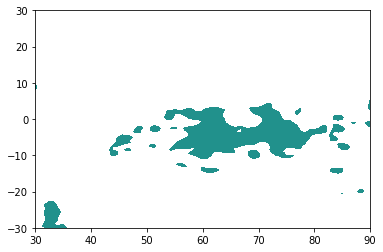

In [6]:
# The littoral contours 
gdf_litt = gp.read_file('Africa_Ecoast_20NS.geojson')
#gdf_litt.plot()

ccvls_stats = [] # empty, to collect the stats of ccvls

# Subset data to the WEIO (30-90E, 30S-30N)
cwv_WEIO = cwv_data.sel(lat=slice(-30,30),lon=slice(30,90))

# To initialize before looping, process the last-most time (index -1) to a gdf
gdf_dest = gdf_from_contours(cwv_WEIO.lon,cwv_WEIO.lat,cwv_WEIO.tqv[INIT_IDX],tqv_conlevel)

# Find coast-overlappers, using query_bulk which returns index arrays
i_litt, i_dest = gdf_dest.sindex.query_bulk(gdf_litt.geometry, predicate='overlaps') 
# i_litt values lie in 0,3 since there are 4 polygons in the littoral gdf

# gdf_ccvls is a SUBSET: I only care about ones that touch the coast
gdf_ccvls = gdf_dest.loc[i_dest].drop_duplicates()
# Must re-index in order for .loc[] to work later in overlap tests 
gdf_ccvls.index = range( len(gdf_ccvls.index) )

# A GeoDataFrame is 1 column with shapes, plus additional columns of attributes.
# Add data columns: time and tag (`tag` is a string, yyyymmddhh_meanlat)
## tag is useful for constructing filenames

# time (given by xarray) appears to be a datetime64 object
yyyymmddhh = cwv_WEIO.time[INIT_IDX].values
print('time level: ', yyyymmddhh)
gdf_ccvls['time'] = yyyymmddhh 

# time as a string (parse through pandas, there are DIFFERENT datetimes, UGH!)
timestring = pd.to_datetime(str(yyyymmddhh)).strftime('%Y_%m_%d_%H')

# mean latitude
centlats = gdf_ccvls.geometry.centroid.y

# need tag to be a string without special characters (- nor .) 
# use N/S rather than dash for sign, and p for "point" in meanlat
# carry 5 characters of abs(meanlat), plenty enough to be unique
NS = ['N','S']
ccvltags = [  timestring+'_lat'+ str(abs(centlats[i]))[:5]   for i in range(len(centlats)) ] 
ccvltags = [ ccvltags[i] + NS[ int(centlats[i]<0) ]   for i in range(len(centlats)) ] 
ccvltags = [ ccvltags[i].replace('.','p') for i in range(len(ccvltags)) ]

gdf_ccvls['tag'] = ccvltags

# Initialize a GDF for each CCVL
### so that shapes at other times can be appended within the time loop 

# Clever trick exec(command), that's how tag can be used as a variable name

## HUGE HEADACHE with append()
## I have to subset using two-index range [0:1] to make it work
## actually, transposing may suffice, .to_frame().T, but this works.
## to make this work: ccvl_2014_05_15_23_lat5p382S.append(ccvl_2014_05_15_23_lat5p577S)

for i in range(len(gdf_ccvls)):
    command = 'ccvl_' + gdf_ccvls.iloc[i].tag + ' = gdf_ccvls.iloc[' +str(i)+':'+str(i+1)+']'
    print('creating gdf_ccvls: ', command)
    exec(command) # creates new gdf for each tag, ready to append 
    # example: 
    # ccvl_2014_05_15_23_lat5p382S = gdf_ccvls.iloc[0:1]
    # creating gdf:  ccvl_2014_06_09_07_lat4p676N = gdf_newccvl.to_frame().T

In [7]:
# --- 
# Discussion of backward time loop action steps 
# We need to  

# 1. Check the overlap of *gdf_now* with pre-existing *gdf_ccvl* shapes
# 1. Transfer CCVL tag to any (all) overlaps with maxlon<89E , discarding others
# 1. Append all non-megalake overlappers to a GDF for each CCVL, ready to write out
# 1. Testing for CCVL birth (present in dest, absent in now). 
      # Write terminated CCVLs as .geojson, and append their duration, areatime, bounds 
      # and other stats to a big Pandas df meta-index of all CCVLs
# 1. Find new coast-crossers now, spawn as new CCVLs IFF they don't exist yet
# 1. Transfer gdf_ccvls_now to gdf_ccvls for next iteration


In [8]:
import warnings
warnings.filterwarnings('ignore')

# a zillion copies of 
# <string>:1: FutureWarning: The frame.append method is deprecated and will be removed 
# from pandas in a future version. Use pandas.concat insttead

In [9]:
#!pwd

In [10]:
#!mkdir GEOJSONS_2014back

In [ ]:
start = timer()

# %debug
# Time loop over ALL hours, backward in time! This is rather dangerously long 
# Safer: a given number of hours, like 365*24 for a year 
# INIT_IDX was crafted above, so we loop over indices not times

# Use while, not for, so that except: can reset it and try again for read errors
it = 0
while it < NHOURS:
# for it in range( NHOURS ):
    iback = INIT_IDX -(it+2)
    timenow = cwv_WEIO.time[iback].values

    # print('time level is ', timenow) #confirms iback goes -2, -3, -4, ... 

# Step 1 in loop: create gdf_now, and find its overlaps with gdf_ccvls. 
# Use Try: except to pocket the gains, in case server times out 

    try: 
        gdf_now = gdf_from_contours(cwv_WEIO.lon,cwv_WEIO.lat,cwv_WEIO.tqv[iback],tqv_conlevel)
    except:
        # Write out the master collection file    
        ccvls_stats.to_csv('ccvls_stats.csv')
        end = timer()
        print(end - start, ' seconds elapsed, at read exception') # Time in seconds
        it=it-1 # next iteration of loop with same it (try again to read the same hour of data)
        continue 
        
    i_ccvls, i_now = gdf_now[(gdf_now.area>0)].sindex.query_bulk(gdf_ccvls.geometry, predicate='overlaps') 

# Step 2 in loop: copy overlappers into gdf_ccvls_now, copy tag, add time.

    # Assign gdf: gdf_ccvls_now, all 'now' objects that are part of a ccvl
    gdf_ccvls_now = gdf_now.loc[i_now]

    # Port the tags from ccvls to ccvls_now
    gdf_ccvls_now['tag'] = gdf_ccvls.iloc[i_ccvls].tag.values
    gdf_ccvls_now['time'] = cwv_WEIO.time[iback].values
    
    # Drop duplicates, and re-index in order for .iloc[] to work later in coast overlap 
    gdf_ccvls_now = gdf_ccvls_now.drop_duplicates()
    num_now = len(gdf_ccvls_now.index)
    gdf_ccvls_now.index = range( num_now )
    
    # if( num_now > 20 ): print('num_now is big: ', num_now, gdf_ccvls)

## Step 3 in loop: Append all gdf_ccvl_now rows onto 
## the existing GDFs for each CCVL, to write out as final result files.

    for iccvl in range( num_now ):
        command = 'ccvl_' + gdf_ccvls_now.iloc[iccvl].tag + ' = ' + \
                  'ccvl_' + gdf_ccvls_now.iloc[iccvl].tag + \
                  '.append(gdf_ccvls_now.iloc[' +str(iccvl)+':'+str(iccvl+1)+'])'
        # print('Step 3, iccvl, appending: ', iccvl, command)
        exec(command) 
        # Example: 
        # ccvl_2014_06_09_01_lat4p387N = ccvl_2014_06_09_01_lat4p387N
        #                               .append(gdf_ccvls_now.iloc[0:1])

## Step 4: terminate tracking of any `dest` ccvls that don't exist `now`

    orphan_tags = pd.concat( [gdf_ccvls_now.tag, gdf_ccvls.tag] ).drop_duplicates(keep=False)

    for i in range(len(orphan_tags)):
        # WRITE OUT CCVL FILE
        outfilename = str(orphan_tags.iloc[i]) + '.geojson'
        command = 'gp.GeoDataFrame(ccvl_' + str(orphan_tags.iloc[i]) + \
                  ').to_file("/Users/bem/GitHub/VaporLakes/GEOJSONS_2014back/' + str(orphan_tags.iloc[i]) + \
                  '.geojson", driver="GeoJSON")'
        print('terminate: ', outfilename)
        exec(command)
        # Example 
        # gp.GeoDataFrame(ccvl_2014_06_09_07_lat4p676N).to_file("2014_06_09_07_lat4p676N.geojson", driver="GeoJSON")


        # GATHER ccvl_stats
        ccvlname = 'ccvl_' + str(orphan_tags.iloc[i])
        command2 = 'dummy = ' + ccvlname + '.copy()'
        exec(command2)

        areatime = dummy['area'].sum()
        maxarea = dummy['area'].max()
        duration = dummy['time'].max() - dummy['time'].min()
        tqv_values = dummy['tqv_values'].mean()
        lasttime = dummy['time'].max()
        ccvl_stats = pd.DataFrame(
            {
             "lasttime": [lasttime],
             "duration": [duration],
             "areatime": [areatime],
             "tqv_values": [tqv_values],
             "maxarea": [maxarea],
             "filename": [outfilename]
            } )
        
        print(ccvl_stats)

        # APPEND ccvl_stats TO ccvls_stats, a growindg index of all CCVLs.
        if(len(ccvls_stats)<1): ccvls_stats = ccvl_stats # first time step
        else: ccvls_stats = ccvls_stats.append(ccvl_stats) # all others

        # DELETE FROM MEMORY in long loops 
        command3 = 'del(ccvl_' + str(orphan_tags.iloc[i]) + ')'
        exec(command3) # example del(ccvl_2014_06_09_07_lat4p676N)
                       
## Step 5: Find NEW ccvl's: coast-crossers now, not in megalake

    i_litt, i_now_cc = gdf_now.sindex.query_bulk(gdf_litt.geometry, predicate='overlaps') 

    for i in np.unique(i_now_cc):  # because a shape may overlap two littoral segments
        if not (i in i_now): # i_now was the overlap of gdf_ccvls with gdf_now

            gdf_newccvl = gdf_now.iloc[i].copy()
            print('adding new ccvl: ', timenow) #gdf_newccvl)

            # add time: uh-oh, is this the same kind of datetime object?? 
            gdf_newccvl['time'] = timenow

            # add tag = timestring + str(meanlat)
            timestring = pd.to_datetime(str(timenow)).strftime('%Y_%m_%d_%H')
            centlat = gdf_newccvl.geometry.centroid.y
            ccvltags = timestring+'_lat'+ str(abs(centlat))[:5]
            ccvltags = ccvltags + NS[ int(centlat<0) ] 
            ccvltags = ccvltags.replace('.','p') 
            gdf_newccvl['tag'] = ccvltags

            # append this new ccvl to ccvls_now
            gdf_ccvls_now = gdf_ccvls_now.append(gdf_newccvl)

            # create the corresponding ccvl_tag... gdf for this new ccvl
            # in transposed form, ready to append onto in next time steps
            command = 'ccvl_' + gdf_newccvl.tag + ' = gdf_newccvl.to_frame().T' 
            exec(command) # creates new gdf
            # example ccvl_2014_06_09_07_lat4p676N = gdf_newccvl.to_frame().T

## Step 6: # re-index, and transfer gdf_ccvls_now to gdf_ccvls for next iteration

    gdf_ccvls = gdf_ccvls_now
    del(gdf_ccvls_now) # empty variable for next time
    
    # re-index 
    gdf_ccvls.index = range( len(gdf_ccvls.index) )

## That was the end of the time loop! 
## Write out ccvls_stats 
ccvls_stats.index = range( len(ccvls_stats) )
print('End of time loop: ccvls_stats')
print(ccvls_stats)
    
## Write out restart files (gdf_ccvls_dest, and the gdf's of all its lakes, ccvl_...)
## and then set up the reading-in code at initiation section 


## Write out any orphans at the last time level: should this be made into a function? 
## Need a unique screening someplace 
orphan_tags = gdf_ccvls.tag.drop_duplicates()
for i in range(len(orphan_tags)):
    # WRITE OUT CCVL FILE
    outfilename = str(orphan_tags.iloc[i]) + '.geojson'
    command = 'gp.GeoDataFrame(ccvl_' + str(orphan_tags.iloc[i]) + \
              ').to_file("/Users/bem/GitHub/VaporLakes/GEOJSONS_2014back/' + str(orphan_tags.iloc[i]) + \
              '.geojson", driver="GeoJSON")'
    print('terminate at end of time loop: ', outfilename)
    exec(command)
    # Example 
    # gp.GeoDataFrame(ccvl_2014_06_09_07_lat4p676N).to_file("2014_06_09_07_lat4p676N.geojson", driver="GeoJSON")


    # GATHER ccvl_stats
    ccvlname = 'ccvl_' + str(orphan_tags.iloc[i])
    command2 = 'dummy = ' + ccvlname + '.copy()'
    exec(command2)

    areatime = dummy['area'].sum()
    maxarea = dummy['area'].max()
    duration = dummy['time'].max() - dummy['time'].min()
    tqv_values = dummy['tqv_values'].mean()
    lasttime = dummy['time'].max()
    ccvl_stats = pd.DataFrame(
        {
         "lasttime": [lasttime],
         "duration": [duration],
         "areatime": [areatime],
         "tqv_values": [tqv_values],
         "maxarea": [maxarea],
         "filename": [outfilename]
        } )

    print(ccvl_stats.drop_duplicates())

    # APPEND ccvl_stats TO ccvls_stats, a growindg index of all CCVLs.
    if(len(ccvls_stats)<1): ccvls_stats = ccvl_stats # first time step
    else: ccvls_stats = ccvls_stats.append(ccvl_stats) # all others

# Write out the master collection file    
ccvls_stats.to_csv('ccvls_stats.csv')

end = timer()
print(end - start, ' seconds elapsed') # Time in seconds, e.g. 5.38091952400282

adding new ccvl:  2014-03-03T00:59:59.999997000
adding new ccvl:  2014-03-02T23:00:00.000003000
terminate:  2014_03_02_23_lat9p209S.geojson
                    lasttime duration  areatime  tqv_values   maxarea  \
0 2014-03-02 23:00:00.000003   0 days  1.339661        55.0  1.339661   

                          filename  
0  2014_03_02_23_lat9p209S.geojson  


Error:curl error: Timeout was reached
curl error details: 


adding new ccvl:  2014-03-02T15:00:00.000000000
terminate:  2014_03_02_15_lat7p943S.geojson
             lasttime               duration  areatime  tqv_values   maxarea  \
0 2014-03-02 15:00:00 0 days 03:59:59.999997  5.931044        55.0  1.277027   

                          filename  
0  2014_03_02_15_lat7p943S.geojson  
adding new ccvl:  2014-03-02T08:00:00.000003000
terminate:  2014_03_02_08_lat12p67S.geojson
                    lasttime               duration   areatime  tqv_values  \
0 2014-03-02 08:00:00.000003 1 days 02:00:00.000003  66.165904        55.0   

    maxarea                         filename  
0  4.315342  2014_03_02_08_lat12p67S.geojson  
adding new ccvl:  2014-03-01T00:00:00.000000000
adding new ccvl:  2014-03-01T00:00:00.000000000
terminate:  2014_03_01_00_lat17p37S.geojson
    lasttime        duration   areatime  tqv_values   maxarea  \
0 2014-03-01 0 days 12:00:00  63.109583        55.0  5.890271   

                          filename  
0  2014_03_01_00_lat17

Error:curl error: Timeout was reached


adding new ccvl:  2013-12-01T18:00:00.000000000
terminate:  2013_12_01_21_lat16p16S.geojson
             lasttime        duration  areatime  tqv_values   maxarea  \
0 2013-12-01 21:00:00 0 days 03:00:00  4.825416        55.0  1.377096   

                          filename  
0  2013_12_01_21_lat16p16S.geojson  
terminate:  2013_12_01_18_lat6p551S.geojson
             lasttime duration  areatime  tqv_values   maxarea  \
0 2013-12-01 18:00:00   0 days  1.520531        55.0  1.520531   

                          filename  
0  2013_12_01_18_lat6p551S.geojson  
adding new ccvl:  2013-12-01T17:00:00.000003000
terminate:  2013_12_01_17_lat6p555S.geojson
                    lasttime duration  areatime  tqv_values   maxarea  \
0 2013-12-01 17:00:00.000003   0 days  2.231054        55.0  2.231054   

                          filename  
0  2013_12_01_17_lat6p555S.geojson  
adding new ccvl:  2013-12-01T15:59:59.999997000
terminate:  2013_12_04_18_lat14p08S.geojson
             lasttime          

In [1]:
ccvls_stats

NameError: name 'ccvls_stats' is not defined

# Examine some outputs

In [117]:
# THIS PLOTS THE CONTOUR AS AN ISOCHRONE, AT EACH HOUR IN THE LIFETIME

# Legend is unreadable, but colorbar tricky to construct 
# Just use title 
# someday, learn: 
# https://stackoverflow.com/questions/30779712/show-matplotlib-colorbar-instead-of-legend-for-multiple-plots-with-gradually-cha

def showme(filename, title):   # like '2014_05_15_02_lat9p247N.geojson'
    gdf = gp.read_file(filename)
    fig, ax = plt.subplots(figsize=[10,8])
    ax.set_aspect('equal')
    ax.set_xlim(30, 93)
    ax.set_ylim(-30,30)

    gdf.drop_duplicates().plot(ax=ax, column='time', facecolor='none', \
                               cmap='jet', alpha=1) #, legend=True)

    #gdf.boundary.plot(ax=ax, color='black')
    path = gp.datasets.get_path('naturalearth_lowres') # Geography background
    mapdf = gp.read_file(path)
    mapdf.boundary.plot(ax=ax)
    
    ax.set_title(title)

    # print(gdf)
    return(gdf)

In [126]:
def plotall(df):

    # LOOP AND PLOT! 
    for i in range(len(df)): 
        showit = df.iloc[i]
        gdf = showme('GEOJSONS/'+showit.filename, 
                     title=showit.duration[0:12] +
                     ' until '+showit.lasttime[0:16]+
                     '    file '+showit.filename)

In [60]:
df = pd.read_csv('ccvls_stats.csv')
df

,Unnamed: 0,lasttime,duration,areatime,tqv_values,maxarea,filename
0,0,2022-02-28 23:00:00.000003,1 days 04:00:00.000006,403.382389,55.0,25.625271,2022_02_28_23_lat15p14S.geojson
1,1,2022-02-27 23:00:00.000003,0 days 04:00:00.000006,84.899747,55.0,25.625271,2022_02_27_23_lat12p49S.geojson
2,2,2022-02-27 23:00:00.000003,0 days 04:00:00.000006,84.899747,55.0,25.625271,2022_02_27_23_lat12p49S.geojson
3,3,2022-02-28 23:00:00.000003,2 days 04:00:00.000006,10891.450478,55.0,398.955285,2022_02_28_23_lat15p73S.geojson
4,4,2022-02-27 12:59:59.999997,0 days 18:00:00,5918.495340,55.0,398.955285,2022_02_27_12_lat14p06S.geojson
...,...,...,...,...,...,...,...
2745,2745,2018-03-03 12:59:59.999997,0 days 06:00:00,2882.466020,55.0,425.849498,2018_03_03_12_lat12p59S.geojson
2746,2746,2018-03-03 03:59:59.999997,0 days 03:00:00,15.982624,55.0,8.214661,2018_03_03_03_lat21p04S.geojson
2747,0,2018-03-02 15:59:59.999997,0 days 16:59:59.999994,5334.687478,55.0,470.258889,2018_03_02_15_lat9p429S.geojson
2748,0,2018-03-02 09:00:00.000000,0 days 09:59:59.999997,84.048796,55.0,9.124369,2018_03_02_09_lat0p592N.geojson


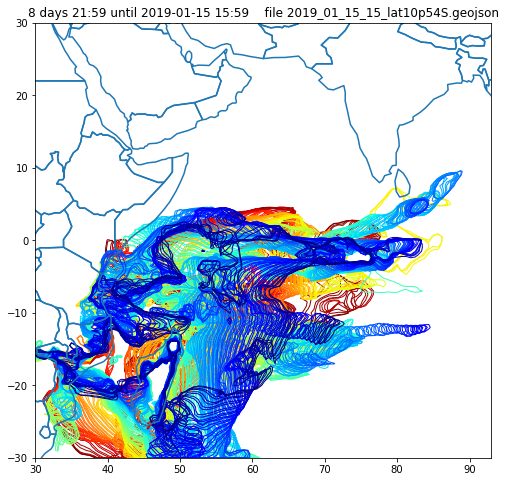

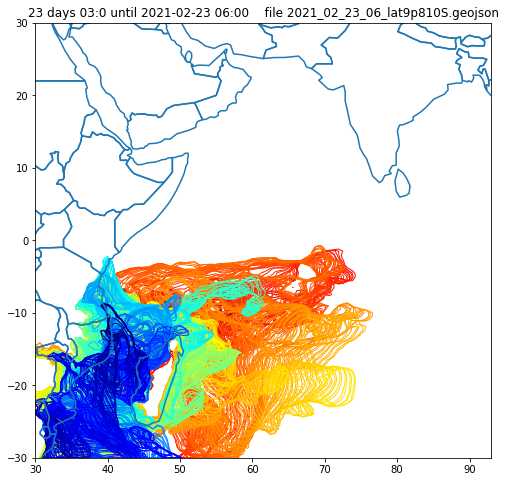

In [127]:
# biggest N. Redundancies appear: they are defined by landfall, 
#             but multiple tentacles can make landfall

N=2

biggies = df.sort_values('areatime', ascending=False)[0:N]
plotall(biggies) 

In [124]:
N=5

longduration = df.sort_values('duration', ascending=False)[0:N]
longduration

,Unnamed: 0,lasttime,duration,areatime,tqv_values,maxarea,filename
786,786,2020-12-20 02:00:00.000003,9 days 23:00:00.000003,10846.284020,55.0,190.853013,2020_12_20_02_lat11p88S.geojson
460,460,2021-04-19 06:59:59.999997,9 days 22:59:59.999994,22612.176600,55.0,151.565933,2021_04_19_06_lat1p387S.geojson
1792,1792,2019-10-12 17:00:00.000003,9 days 13:00:00.000006,14076.928088,55.0,89.943438,2019_10_12_17_lat5p763S.geojson
1724,1724,2019-11-13 18:59:59.999997,9 days 12:59:59.999997,20252.626296,55.0,156.605414,2019_11_13_18_lat4p047S.geojson
1740,1740,2019-11-05 09:00:00.000000,9 days 12:00:00,4475.702481,55.0,53.038926,2019_11_05_09_lat6p660N.geojson


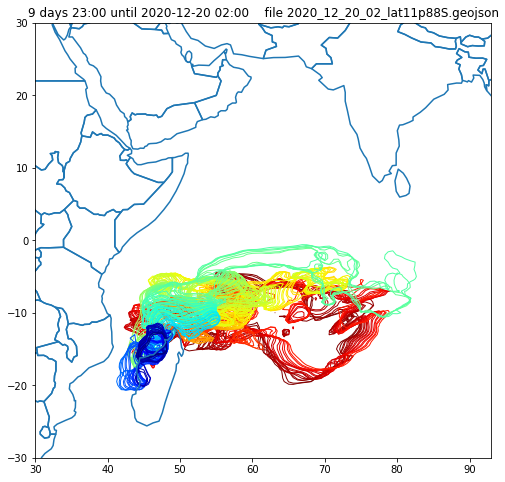

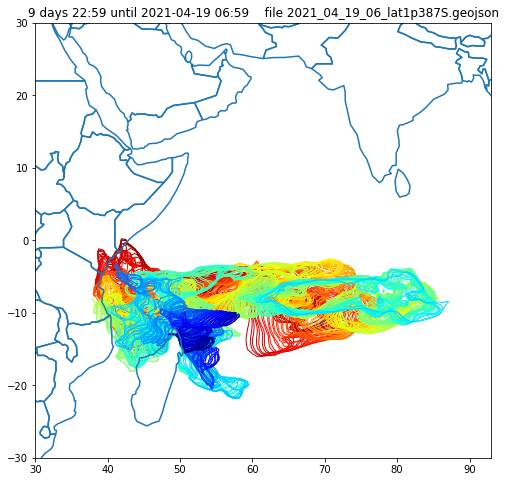

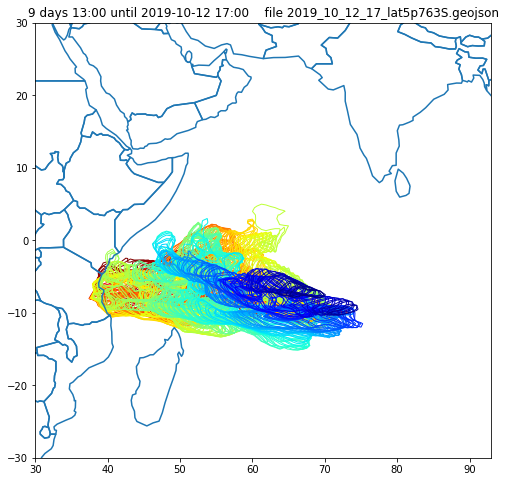

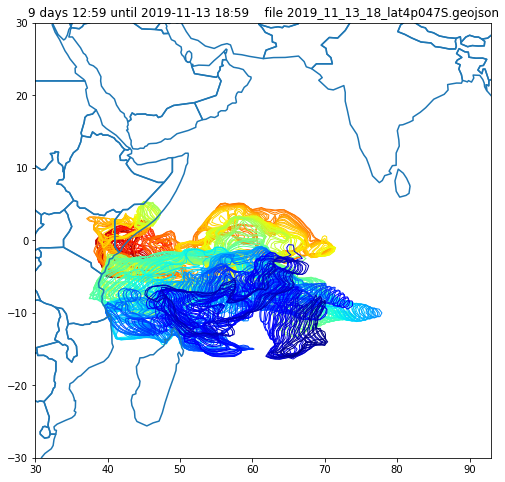

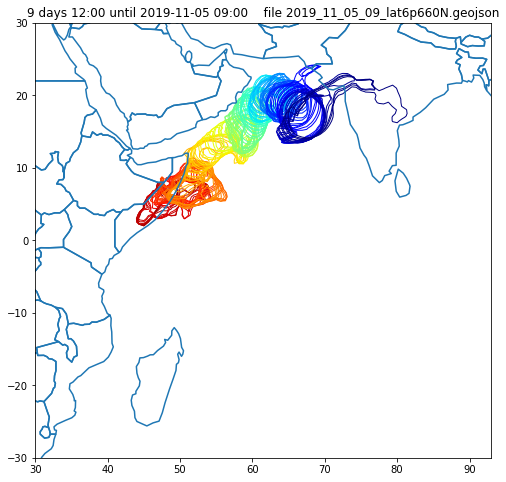

In [128]:
plotall(longduration)